recommended \
`jupyter lab` \
running python 3.6+.\
use \
    `pip3 install <package>`\
to install missing packages. \
add `--user` at the end of the command if you don't have superuser privileges

## modules

In [116]:
# numeric arrays
from numpy import *
# optimizition
import numba
# plotting
import matplotlib.pyplot as plt
# jupyter magic command for plot display
%matplotlib inline
# plotting setup
plt.rcParams.update({
    "image.origin": "lower",
    "font.family": "serif",
    "font.size": 12,
    "grid.alpha": .5,
#     "text.usetex": True, # I was not able to load the livetex package
})
# statistical functions
import scipy.stats
# compressed sparse row matrices
from scipy.sparse import csr_matrix
# variable length arrays
import awkward as ak
# labeled arrays
import xarray as xr
# memory debugging
from memory_profiler import profile
# jupyter magic
%load_ext memory_profiler
%load_ext line_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Cached decorator

In [50]:
class CachedAttribute(object):    
    '''Computes attribute value and caches it in the instance.
    From the Python Cookbook (Denis Otkidach)
    This decorator allows you to create a property which can be computed once and
    accessed many times. Sort of like memoization.
    '''
    def __init__(self, method, name=None):
        # record the unbound-method and the name
        self.method = method
        self.name = name or method.__name__
        self.__doc__ = method.__doc__
    def __get__(self, inst, cls):
        # self: <__main__.cache object at 0xb781340c>
        # inst: <__main__.Foo object at 0xb781348c>
        # cls: <class '__main__.Foo'>       
        if inst is None:
            # instance attribute accessed on class, return self
            # You get here if you write `Foo.bar`
            return self
        # compute, cache and return the instance's attribute value
        result = self.method(inst)
        # setattr redefines the instance's attribute so this doesn't get called again
        setattr(inst, self.name, result)
        return result

## Kernel class

In [526]:
# nu = ones(r.shape[0])
def Wfunc(q):
    return scipy.stats.norm.pdf(q, 1) if q < 2. else 0.
Wvec = vectorize(Wfunc)
h = 1.
Wvec(0)
class BaseKernel:
    def __call__(self, delta_r):
        pass

class Vectorized(BaseKernel):
    def __init__(self, h, dim):
        self.k = [ 2/(3*h), 10/(7*pi*h**2), 1/(pi*h**3) ][dim-1]        
        self.h = h
        self._func = vectorize(self._core)
        
    def _core(self, q):
        if q > 2: return 0
        if q > 1: return 1./4 * (2. - q)**3
        return 1 - 3/2*q**2*( 1 - q/2 )
    
    def __call__(self, delta_r):
        return self._func( abs(delta_r)/self.h )*self.k
    
class CSpline(BaseKernel):
    def __init__(self, h, dim):
        self.k = [ 2/(3*h), 10/(7*pi*h**2), 1/(pi*h**3) ][dim]
        self.h = h
        
    @staticmethod
    def _part_0(q):
        return 1 - 3/2*q**2*( 1 - q/2 )
    
    @staticmethod
    def _part_1(q):
        return 1./4 * (2. - q)**3
    
    def _core(self, q):
        ret = zeros_like(q)
        ret[ logical_and( q >=1, q<2 ) ] = self._part_1( q[ logical_and( q >=1, q<2 ) ] )
        ret[ q < 1 ] = self._part_0( q[q < 1] )
        return ret
    
    def __call__(self, delta_r):
        return self._core(abs(delta_r)/self.h)*self.k

@numba.vectorize([numba.float64(numba.float64)])
def core_1d(q):
    if q > 2: return 0
    if q > 1: return 1./4 * (2. - q)**3
    return 1 - 3/2*q**2*( 1 - q/2 )

class CSplineNB(BaseKernel):
    def __init__(self, h, dim):
        self.k = [ 2/(3*h), 10/(7*pi*h**2), 1/(pi*h**3) ][dim-1]
        self.h = h
        
    def __call__(self, delta_r):
        return core_1d(abs(delta_r)/self.h)*self.k

class QSpline(BaseKernel):
    pass

In [13]:
%prun Vectorized(1.,1)( linspace(-3,3,int(1e5)) )

         100063 function calls (100060 primitive calls) in 0.093 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100001    0.047    0.000    0.047    0.000 <ipython-input-9-dbf26a538e4c>:17(_core)
        1    0.033    0.033    0.089    0.089 function_base.py:2179(_vectorize_call)
        6    0.008    0.001    0.008    0.001 {built-in method numpy.array}
        1    0.002    0.002    0.091    0.091 function_base.py:2080(__call__)
        1    0.001    0.001    0.001    0.001 function_base.py:23(linspace)
        1    0.001    0.001    0.092    0.092 <ipython-input-9-dbf26a538e4c>:22(__call__)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.abs}
        1    0.000    0.000    0.093    0.093 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 function_base.py:2110(_get_ufunc_and_otypes)
      4/1

In [12]:
%prun CSpline(1.,1)( linspace(-3,3,int(1e5)) )

         52 function calls (47 primitive calls) in 0.009 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.005    0.005    0.005    0.005 <ipython-input-9-dbf26a538e4c>:34(_part_1)
        1    0.001    0.001    0.007    0.007 <ipython-input-9-dbf26a538e4c>:38(_core)
        1    0.001    0.001    0.001    0.001 function_base.py:23(linspace)
        1    0.001    0.001    0.008    0.008 <ipython-input-9-dbf26a538e4c>:44(__call__)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        1    0.000    0.000    0.000    0.000 <ipython-input-9-dbf26a538e4c>:30(_part_0)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.abs}
      7/2    0.000    0.000    0.001    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.009    0.009 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {meth

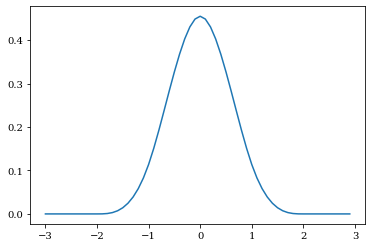

In [14]:
W = CSpline(1., 1)
x = arange(-3,3,.1)
plt.plot( x, W(x) )

## BaseSystem

In [17]:
class BaseSystem:
    def __init__(self, h, W, r=None, nu=None, N=None, dim=None ):
        self._h = h
        if r is None:
            self._N, self._dim = N, dim
            self._r = random.normal(0, 1, (N,dim) )
        else:
            self._r = r
            self._N, self._dim = r.shape
        if type(W) is type:
            self._W = W(dim=self._dim, h=self._h)
        if nu is None:
            self._nu = ones(self._N)
        else:
            self._nu = nu
    
    def rho(self):
        pass
    
    def dist(self):
        pass
    

## BruteForce class

In [518]:
class BruteForce(BaseSystem):
    def delta_r(self):
        return self._r[:,None,:] - self._r[None,:,:]
    
    def dist(self):
        return sqrt( sum(self.delta_r()**2, axis=-1) )
    
    @CachedAttribute
    def rho(self):
        return sum( self._nu[:, None]*self._W(self.dist()), axis=0 )

In [520]:
Ns = [10, 100, int(1e3), int(1e4), 2*int(1e4) ]
for N in Ns:
    print("N=", N)
    %time BruteForce(N=N, dim=2, h=.2, W=CSplineNB).rho

N= 10
CPU times: user 182 µs, sys: 48 µs, total: 230 µs
Wall time: 205 µs
N= 100
CPU times: user 1.16 ms, sys: 1.79 ms, total: 2.95 ms
Wall time: 1.62 ms
N= 1000
CPU times: user 40.3 ms, sys: 975 µs, total: 41.3 ms
Wall time: 40.9 ms
N= 10000
CPU times: user 3.91 s, sys: 2.37 s, total: 6.27 s
Wall time: 6.27 s
N= 20000
CPU times: user 16.3 s, sys: 10.8 s, total: 27 s
Wall time: 27 s


In [224]:
%prun BruteForce( N=int(1e4), h=.2, dim=2, W=CSplineNB ).rho()

         34 function calls in 5.508 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    2.065    1.033    2.065    1.033 {method 'reduce' of 'numpy.ufunc' objects}
        1    1.455    1.455    1.455    1.455 <ipython-input-214-b4dec1537647>:2(delta_r)
        1    0.665    0.665    1.010    1.010 <ipython-input-80-b15176aa07c9>:58(__call__)
        1    0.665    0.665    4.113    4.113 <ipython-input-214-b4dec1537647>:5(dist)
        1    0.345    0.345    0.345    0.345 {built-in method builtins.abs}
        1    0.311    0.311    5.507    5.507 <ipython-input-214-b4dec1537647>:8(rho)
        1    0.001    0.001    0.001    0.001 {method 'normal' of 'numpy.random.mtrand.RandomState' objects}
        1    0.000    0.000    5.508    5.508 {built-in method builtins.exec}
        2    0.000    0.000    2.066    1.033 fromnumeric.py:2105(sum)
        2    0.000    0.000    2.065    1.033 fromnumeric.py:70(_wrapreduct

(10, 100, 1000) (4.71, 314, 30000.0)


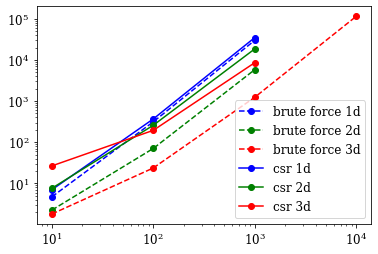

In [81]:
brute_force_times_1d={
    10: 4.71,
    100: 314,
    1000: 30e3
}
brute_force_times_2d={
    10: 2.24,
    100: 70.7,
    1000: 5.82e3
}
brute_force_times_3d={
    10: 1.8,
    100: 23.7,
    1000: 1.24e3,
    10000: (60+55)*1e3,
}

ax = plt.figure().subplots()
ax.set_yscale("log")
ax.set_xscale("log")
print( *zip(*brute_force_times_1d.items() ) )
ax.plot( *zip(*brute_force_times_1d.items()), 'bo--', label="brute force 1d" )
ax.plot( *zip(*brute_force_times_2d.items()), 'go--', label="brute force 2d" )
ax.plot( *zip(*brute_force_times_3d.items()), 'ro--', label="brute force 3d" )

ax.plot( *zip(*csr_np_times_1d.items()), 'bo-', label="csr 1d" )
ax.plot( *zip(*csr_np_times_2d.items()), 'go-', label="csr 2d" )
ax.plot( *zip(*csr_np_times_3d.items()), 'ro-', label="csr 3d" )
ax.legend()

In [310]:
x = mgrid[-3:3:h/2, -3:3:h/2].T
x.shape

(12, 12, 2)

In [311]:
# print( vW( abs(r.cross_sub(x)) ) )

In [312]:
rho_x = sum( nu[:,None,None] * vW( abs(r.cross_sub(x))/h ), axis=0 )
rho_x.shape

abs


(12, 12)

<AxesSubplot:>

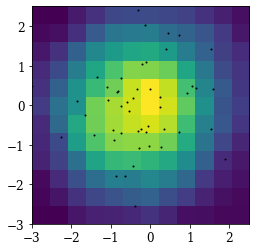

In [313]:
ax = plt.figure().subplots()
ax.scatter(*r.xy(), c='black', s=1)
ax.imshow( rho_x, extent=[ amin(x[:,:,0]), amax(x[:,:,0]), amin(x[:,:,1]), amax(x[:,:,1])] )
ax

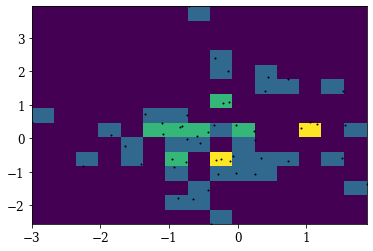

In [314]:
ax = plt.figure().subplots()
ax.hist2d(*r.xy(), 15)
ax.scatter(*r.xy(), c='black', s=1)

## csr index magic

center at function [2 2] 2
shifts [[[2]]

 [[2]]] (2, 1, 1)
shifts [[[-2 -2 -2 -2 -2]
  [-1 -1 -1 -1 -1]
  [ 0  0  0  0  0]
  [ 1  1  1  1  1]
  [ 2  2  2  2  2]]

 [[-2 -1  0  1  2]
  [-2 -1  0  1  2]
  [-2 -1  0  1  2]
  [-2 -1  0  1  2]
  [-2 -1  0  1  2]]] (2, 5, 5)
unfolded_shifts [-38 -37 -36 -35 -34 -20 -19 -18 -17 -16  -2  -1   0   1   2  16  17  18
  19  20  34  35  36  37  38] (25,)
rho.shape (1000,)


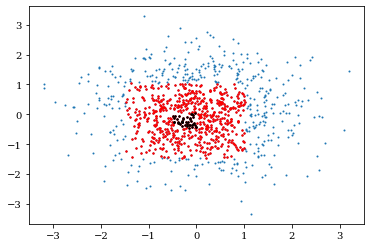

In [27]:
shape = (1000,2)
r = random.normal(0, 1, shape)

def digitize_dd(arr, binsize, border=None, center=True, axis=0):
    if center:
        arr = arr - mean(arr, axis=axis)
    digitized = floor(arr/binsize).astype(int)
    digitized = digitized - amin(digitized, axis=axis)
    extra = 1
    if not border is None:
        digitized += border
        extra += border
    return digitized, amax(digitized, axis=axis) + extra

def flatten(arr, shape):
    return ravel_multi_index( arr.T, shape.T )

def fold(arr, shape):
    return array(unravel_index( arr, shape.T )).T

def shifts(center, border):
    center = array(center)
    length = center.shape[-1]
    shifts = mgrid[ tuple([ slice(-border, border+1) ]*length) ]
    print( "center at function", center, length )
    print( "shifts", center[ tuple([slice(None)] + [None]*length) ], center[ tuple([slice(None)] + [None]*length) ].shape )
    print( "shifts", shifts, shifts.shape )
    return (center[ tuple([slice(None)] + [None]*length) ] + shifts).T

def build(arr, h, border):
    digitized, shape = digitize_dd(arr, h, border)
    flat = flatten( digitized, shape )
    occupiedbins = unique( flat )
    center = array([border]*len(shape))
    unfolded_shifts = flatten(shifts(center, border), shape).flatten() - flatten(center, shape).flatten()[0]
    print( "unfolded_shifts", unfolded_shifts, unfolded_shifts.shape )
    ptr = arange(arr.shape[0])
    S = csr_matrix( (ptr, (flat, ptr)), shape=(prod(shape), arr.shape[0]) )
    pointers = array( [ group for group in split(S.data, S.indptr[1:-1])], dtype=object )

    def get_positions(ibin):
        ipointer = occupiedbins[ibin]
        indices = pointers[ipointer] 
        return indices
    def get_neighbors(ibin):
        ipointer = occupiedbins[ibin]
        indices = concatenate( pointers[ ipointer + unfolded_shifts ] )
        return indices
    def summation( arg, kernel ):
        ret = zeros( arg.shape[0] )
#         print( ret.shape )
        for ibin, ipointer in enumerate(occupiedbins):
            indices = get_positions(ibin)
            neighbor_indices = get_neighbors(ibin)
#             print( indices, "\n", neighbor_indices )
            q = sqrt(sum( (arr[None,indices,:] - arr[neighbor_indices,None,:])**2, axis=-1))
            ret[indices] = sum( arg[neighbor_indices,...] * kernel(q), axis=0 )
        return ret
    return get_positions, get_neighbors, summation

h = .5
get_positions, get_neighbors, summation_ = build(r, h, 2)
rho = summation_( ones_like(r[:,0])[:,None], CSpline(dim=r.shape[1],h=h) )
print( "rho.shape", rho.shape )
ibin = 50
ax = plt.figure().subplots()
ax.scatter( *r.T, s=1)
ax.scatter( *r[get_neighbors(ibin)].T, s=2, c='red' )
ax.scatter( *r[get_positions(ibin)].T, s=2, c='black' )

## CSR class

In [515]:
class CSR_sum:
    def __init__(self, method, name=None):
        self.method = method
        self.name = name or method.__name__
        self.__doc__ = method.__doc__
    
    def __get__(self, obj, cls):
        arr, broadcast = self.method(obj)
        ret = zeros_like( arr )
        for a, b in zip(obj._occupants, obj._neighbors):
            delta_r = sqrt(sum( (obj._r[None, a,:] - obj._r[b, None, :])**2, axis=-1))
            ret[a] = sum( arr[b][broadcast] * obj._W(delta_r), axis=0 )
        setattr(obj, self.name, ret)
        return ret

class CSR(BaseSystem):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._border = 2
        self._initialize_indices()
        
    @CachedAttribute
    def _digitized(self):
        r = self._r - mean(self._r, axis=0)
        digitized = floor(r/self._h).astype(int)
        digitized -= amin(digitized, axis=0)
        digitized += self._border
        return digitized
    
    @CachedAttribute
    def _digitized_shape(self):
        return amax(self._digitized, axis=0) + 1 + self._border
    
    @CachedAttribute
    def _flat_digitized(self):
        return self.flatten( self._digitized.T )
        
    def flatten(self, nd):
        return ravel_multi_index( nd, self._digitized_shape )
    
    @CachedAttribute
    def _occupied_bins(self):
        return unique(self._flat_digitized)
    
    @CachedAttribute
    def _Nrange(self):
        nrange = arange( self._N )
        return nrange
    
    @CachedAttribute
    def _border_dd(self):
        return array( [self._border]*self._dim )
    
#     @CachedAttribute
#     def _shifts_dd(self):
#         shifts_ = mgrid[ tuple([ slice(-self._border, self._border+1) ]*self._dim) ]
#         center_ = self._border_dd[ tuple([slice(None)] + [None]*self._dim) ]
#         offset = ( center_ + shifts_ ).T
#         return offset

    @CachedAttribute
    def _shifts_dd(self):
        return mgrid[ tuple([ slice(-self._border, self._border+1) ]*self._dim) ] + self._border
    
    @CachedAttribute
    def _shifts_1d(self):
        _shifts_1d = self.flatten( self._shifts_dd ).flatten() 
        _shifts_1d -= self.flatten( self._border_dd ).flatten()[0]
        return _shifts_1d
        
    def _initialize_indices(self):
        S = csr_matrix( 
            (self._Nrange, (self._flat_digitized, self._Nrange) ), 
            shape=( prod(self._digitized_shape), self._N ),
        )
        self._pointers = array( [ group for group in split(S.data, S.indptr[1:-1])], dtype=object )
    
    @CachedAttribute
    def _occupants(self):
        return self._pointers[ self._occupied_bins ]
        
    @CachedAttribute
    def _neighbors(self):
        neighbors = [ 
            concatenate( self._pointers[ ipointer + self._shifts_1d ] ) 
            for ipointer in self._occupied_bins 
        ]
        return neighbors
    
    @CachedAttribute
    def kernel(self):
        for a, b in zip(self._occupants, self._neighbors):
            pass
    
    @CachedAttribute
    def rho_cache(self):
        ret = zeros_like( self._nu )
        for a, b in zip(self._occupants, self._neighbors):
            delta_r = sqrt(sum( (self._r[None, a,:] - self._r[b, None, :])**2, axis=-1))
            ret[a] = sum( self._nu[b, None] * self._W(delta_r), axis=0 )
        return ret
    
    @CSR_sum
    def rho(self):
        return self._nu, (slice(None), None)

    @CSR_sum
    def ones(self):
        return 1/self.rho, (slice(None), None)
    

In [516]:
init = dict(
    h=.2, 
    W=CSplineNB, 
    r=random.normal( 0, 1., (int(5e4),2) ) 
)
csr = CSR(**init)
# print( csr._nu.shape )
%time print( csr.rho[:10] )
%time print( csr.rho[:10] )

[ 7633.34642964 20478.76407201 13912.58092844 24918.98617278
  5135.49376697  4033.80723115 16534.22202057 26052.73434083
  7193.87305165  2077.36784089]
CPU times: user 7.51 s, sys: 147 ms, total: 7.66 s
Wall time: 7.66 s
[ 7633.34642964 20478.76407201 13912.58092844 24918.98617278
  5135.49376697  4033.80723115 16534.22202057 26052.73434083
  7193.87305165  2077.36784089]
CPU times: user 329 µs, sys: 0 ns, total: 329 µs
Wall time: 303 µs


In [512]:
amax(csr.ones - 1)

0.1691682981151721

### test consistency

In [527]:
init = dict(
    h=.2, 
    W=CSplineNB, 
    r=random.normal( 0, 1., (100,3) ) 
)
CSR(**init).rho - BruteForce(**init).rho

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.42108547e-14,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### time

In [438]:
Ns = [10, 100, int(1e3), int(1e4), 2*int(1e4), 3*int(1e4), int(1e5) ]
init = dict(N=N, dim=2, h=.2, W=CSplineNB)
for N in Ns:
    init = dict(N=N, dim=2, h=.2, W=CSplineNB)
    print("N=", N)
    print("init")
    csr = %time CSR(**init)
    print("rho")
    %time csr.rho
    print("second call rho")
    %time csr.rho

N= 10
init
CPU times: user 5.16 ms, sys: 48 µs, total: 5.21 ms
Wall time: 4.23 ms
rho
funcname rho
CPU times: user 2.71 ms, sys: 1.22 ms, total: 3.93 ms
Wall time: 3.08 ms
second call rho
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs
N= 100
init
CPU times: user 5.84 ms, sys: 282 µs, total: 6.12 ms
Wall time: 5.99 ms
rho
funcname rho
CPU times: user 7.99 ms, sys: 0 ns, total: 7.99 ms
Wall time: 7.8 ms
second call rho
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs
N= 1000
init
CPU times: user 8.44 ms, sys: 85 µs, total: 8.52 ms
Wall time: 8.23 ms
rho
funcname rho
CPU times: user 35.7 ms, sys: 101 µs, total: 35.8 ms
Wall time: 35.5 ms
second call rho
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs
N= 10000
init
CPU times: user 10.3 ms, sys: 84 µs, total: 10.4 ms
Wall time: 9.24 ms
rho
funcname rho
CPU times: user 454 ms, sys: 0 ns, total: 454 ms
Wall time: 452 ms
second call rho
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7

### prun

In [264]:
csr = CSR( N=int(2e4), h=.2, dim=2, W=CSplineNB )
%prun csr.rho()

         19658 function calls (19655 primitive calls) in 1.332 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1706    0.608    0.000    0.608    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.573    0.573    1.332    1.332 <ipython-input-219-692eb8f60c2f>:67(rho)
      853    0.095    0.000    0.115    0.000 <ipython-input-80-b15176aa07c9>:58(__call__)
      853    0.021    0.000    0.021    0.000 {built-in method builtins.abs}
2563/2561    0.016    0.000    0.635    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.005    0.005    0.021    0.021 <ipython-input-219-692eb8f60c2f>:62(<listcomp>)
     1706    0.003    0.000    0.613    0.000 fromnumeric.py:70(_wrapreduction)
     1706    0.003    0.000    0.617    0.000 fromnumeric.py:2105(sum)
     1706    0.002    0.000    0.621    0.000 <__array_function__ internals>:2(sum)
        1    0.002    0.002    0.00

### N= 100 dim= 1
###### 293 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 296 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 289 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### N= 200 dim= 1
###### 1.12 s ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 1.19 s ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 1.31 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### N= 300 dim= 1
###### 2.52 s ± 73.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 2.63 s ± 94.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 2.56 s ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### N= 400 dim= 1
###### 4.48 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 4.59 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 4.53 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### N= 500 dim= 1
###### 7.44 s ± 593 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 7.42 s ± 589 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 6.8 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### N= 600 dim= 1
###### 10.1 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 10.1 s ± 371 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
###### 10 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 700 dim= 1
13.8 s ± 376 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.7 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.6 s ± 689 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 800 dim= 1
19.8 s ± 1.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.7 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.4 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 900 dim= 1
23.7 s ± 999 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.5 s ± 1.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
26.4 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 1000 dim= 1
33.8 s ± 507 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.2 s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
28 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 100 dim= 2
66.6 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
84.8 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.8 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
### N= 200 dim= 2
237 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
266 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
271 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 300 dim= 2
554 ms ± 71.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
550 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
550 ms ± 6.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 400 dim= 2
922 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
927 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
993 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 500 dim= 2
1.43 s ± 66.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.45 s ± 98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 600 dim= 2
2.07 s ± 42.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2 s ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.95 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 700 dim= 2
2.71 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.65 s ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.55 s ± 44.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 800 dim= 2
3.48 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.32 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.22 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 900 dim= 2
4.33 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.19 s ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.14 s ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 1000 dim= 2
5.67 s ± 479 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.21 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.1 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 100 dim= 3
21.9 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
97.5 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.8 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
### N= 200 dim= 3
63.4 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
161 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
### N= 300 dim= 3
122 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
250 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
159 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
### N= 400 dim= 3
206 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
340 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
232 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 500 dim= 3
311 ms ± 9.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
415 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
330 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 600 dim= 3
418 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
529 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
421 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 700 dim= 3
553 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
657 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
562 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 800 dim= 3
723 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
832 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
697 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 900 dim= 3
895 ms ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.12 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
994 ms ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### N= 1000 dim= 3
1.23 s ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.27 s ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.08 s ± 97.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [79]:
csr_np_times_1d = {
    10: 7,
    100: 369,
    1000: 35e3
}
csr_np_times_2d = {
    10: 7.6,
    100: 259,
    1000: 18.6e3
}
csr_np_times_3d = {
    10: 26.6,
    100: 195,
    1000: 8.6e3
}


## xArray

In [301]:
class XArray(BaseSystem):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ds = xr.Dataset( dict( 
            positions = (["a","i"], self._r),
            weights = (["a"], self._nu),
        ) )
        self._border = 2
        self._initialize()

    @CachedAttribute
    def _digitized(self):
        r = self.ds.positions - self.ds.positions.mean('a')
        digitized = floor(r/self._h).astype(int)
        digitized -= amin(digitized, axis=0)
        digitized += self._border
        return digitized

    @property
    def _digitized_shape(self):
        return self._digitized.max("a").data + 1 + self._border

    def flatten(self, nd):
        return ravel_multi_index( nd.T, self._digitized_shape.T )
    
    @property
    def ndshifts(self):
        return mgrid[[slice(-self._border, self._border+1)]*self._dim]
    
    @property
    def shifts(self):
        offset_shifts = ravel_multi_index( self.ndshifts + self._border, self._digitized_shape ).flatten()
        return offset_shifts - ravel_multi_index( [self._border]*self._dim , self._digitized_shape )
    
    @property
    def flat_indices(self):
        return ravel_multi_index( self._digitized.transpose("i","a"), self._digitized_shape )
    
    def _initialize(self):
        
        self.ds.coords['a'] = self.flat_indices
        self._occupants = self.ds.groupby('a').groups

        self._neighbors = {}
        [ 
            self._neighbors.setdefault(ptr + offset, []).extend( indices ) 
            for ptr, indices in self._occupants.items() for offset in self.shifts 
        ]

    def rho2(self):
        self.ds.update( dict(
            rho = (["a"], zeros_like(self.ds.weights))
        ))
        for key, a in self._occupants.items():
            b = self._neighbors[key]
            dists = sqrt( ((self.ds.positions.isel(a=a) - self.ds.positions.isel(a=b).rename({"a":"b"}))**2).sum('i') )
            self.ds.rho.data[a] = ( self.ds.weights.isel(a=a) * xr.apply_ufunc( self._W, dists ) ).sum('b')
        return self.ds.rho
    
    def rho(self):
        self.ds.update( dict(
            rho = (["a"], zeros_like(self.ds.weights))
        ))
        r = self.ds.positions.data
        for key, a in self._occupants.items():
            b = self._neighbors[key]
            dists = sqrt( (( r[None, a, :] - r[b, None, :])**2).sum(-1) )
            self.ds.rho.data[a] = ( self.ds.weights.data[b, None] * self._W( dists ) ).sum(0)
        return self.ds.rho
    
    def __str__(self):
        return str(self.ds)

### test zero

In [307]:
init = dict(
    h=.2, 
    W=CSplineNB, 
    r=random.normal( 0, 1., (int(1e4),2) ) 
)
print( XArray(**init).rho() - BruteForce(**init).rho() )

<xarray.DataArray 'rho' (a: 10000)>
array([3.63797881e-12, 1.36424205e-12, 9.09494702e-13, ...,
       4.54747351e-13, 0.00000000e+00, 5.45696821e-12])
Coordinates:
  * a        (a) int64 1079 731 813 937 899 556 898 ... 510 456 1035 996 770 908


### time

In [294]:
Ns = [10, 100, int(1e3), int(1e4), 2*int(1e4), 3*int(1e4), int(1e5) ]
for N in Ns:
    init = dict(N=N, dim=2, h=.2, W=CSplineNB)
    print("N=", N)
    %time XArray(**init).rho()
#     xarr = XArray(**init)
#     %time xarr.rho()
#     %time xarr.rho()

N= 10
CPU times: user 26.4 ms, sys: 2.22 ms, total: 28.6 ms
Wall time: 26.1 ms
N= 100
CPU times: user 91 ms, sys: 0 ns, total: 91 ms
Wall time: 90.9 ms
N= 1000
CPU times: user 389 ms, sys: 2.77 ms, total: 392 ms
Wall time: 391 ms
N= 10000
CPU times: user 1.11 s, sys: 36 µs, total: 1.11 s
Wall time: 1.11 s
N= 20000
CPU times: user 2.32 s, sys: 22 µs, total: 2.32 s
Wall time: 2.32 s
N= 30000
CPU times: user 4.19 s, sys: 656 µs, total: 4.19 s
Wall time: 4.19 s
N= 100000
CPU times: user 35.1 s, sys: 12.4 s, total: 47.5 s
Wall time: 47.5 s


### prun

In [303]:
xarr = XArray( N=int(2e4), h=.2, dim=2, W=CSplineNB )
%prun xarr.rho()

         581383 function calls (574602 primitive calls) in 1.675 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.614    0.614    1.675    1.675 <ipython-input-301-6e95c757e037>:60(rho)
     1684    0.543    0.000    0.543    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      842    0.088    0.000    0.109    0.000 <ipython-input-80-b15176aa07c9>:58(__call__)
     5063    0.054    0.000    0.327    0.000 dataset.py:1254(_construct_dataarray)
    35453    0.027    0.000    0.046    0.000 typing.py:1223(__new__)
      842    0.021    0.000    0.021    0.000 {built-in method builtins.abs}
    28692    0.017    0.000    0.024    0.000 _collections_abc.py:742(__iter__)
    15215    0.016    0.000    0.016    0.000 {built-in method builtins.hasattr}
     5064    0.014    0.000    0.075    0.000 coordinates.py:205(variables)
     5064    0.013    0.000    0.038    0.000 coordinates.py:208(<dictcomp>)
     5065   

In [304]:
print( xarr )

<xarray.Dataset>
Dimensions:    (a: 20000, i: 2)
Coordinates:
  * a          (a) int64 1175 758 659 808 667 1084 ... 1304 892 942 991 1127 661
Dimensions without coordinates: i
Data variables:
    positions  (a, i) float64 0.9806 0.309 -0.8735 ... -0.1267 -1.381 -1.234
    weights    (a) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    rho        (a) float64 6.363e+03 7.12e+03 1.198e+03 ... 8.143e+03 2.176e+03


In [32]:
digitized, shape = digitize_dd( ds.positions.data, h, 2 )
# print( digitized.shape, amin(digitized, axis=0), amax(digitized, axis=0) )
flat = flatten( digitized, shape )
# print( flat[:10] )
ds.coords['a'] = flat
grouped = ds.groupby('a')
occupants = grouped.groups
occupants.items()

dict_items([(37, [82]), (57, [134]), (59, [5, 852]), (60, [673, 722]), (61, [872]), (62, [333]), (71, [778]), (73, [396]), (74, [237]), (75, [194, 442, 548]), (76, [63, 95, 743, 825]), (77, [343, 441, 558, 874, 928, 962, 965]), (78, [48, 995]), (80, [732]), (89, [692]), (90, [860, 985]), (91, [7, 805, 846, 976]), (92, [89, 180, 304, 345, 468, 476, 550, 554, 980]), (93, [20, 24, 141, 149, 320, 648, 907]), (94, [77, 115, 140, 745]), (95, [220, 381, 701]), (96, [18, 120, 761, 782, 871]), (97, [151]), (106, [355, 695]), (107, [92, 102, 794, 909, 993]), (108, [84, 192, 248, 330, 521, 565, 595, 668, 905, 927]), (109, [26, 57, 214, 293, 336, 384, 477, 571, 629, 699, 767, 775, 917, 943]), (110, [66, 105, 216, 279, 298, 368, 454, 581, 587, 641, 665, 705, 786, 845]), (111, [139, 231, 258, 327, 331, 388, 638, 774, 788, 881]), (112, [191, 326, 511, 631, 643, 649, 944, 949]), (113, [125, 166, 183, 312, 424, 502, 566, 640, 829, 896]), (114, [173, 429, 486, 903]), (115, [394]), (116, [70]), (121, [49

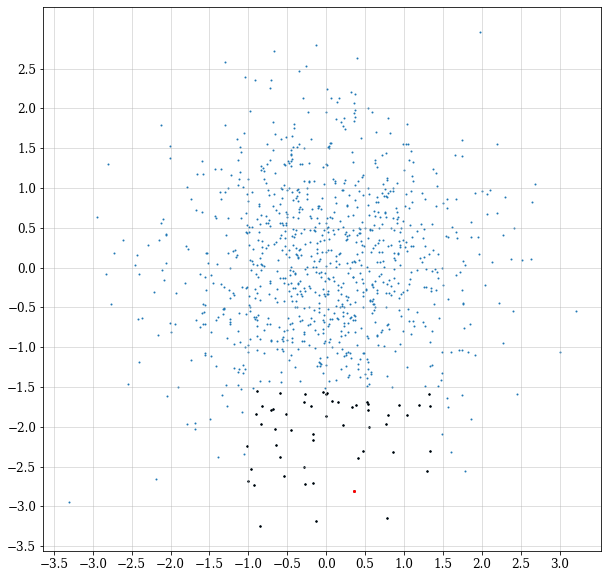

In [44]:
# print( grouped.groups )
# print( occupants[150] )
# print( ds.positions[occupants[150]] )

border = 2
center = array([border]*len(shape))
# print( center )
unfolded_shifts = flatten( shifts(center, border), shape).flatten() - flatten(center, shape).flatten()[0]
# print( unfolded_shifts )
neighbors = {}

[ neighbors.setdefault(ptr + offset, []).extend( indices ) for ptr, indices in occupants.items() for offset in unfolded_shifts ]

ax = plt.figure(figsize=(10,10)).subplots()
ax.scatter( *ds.positions.transpose("i", "a"), s=1)
n = 60
key = list(occupants.keys())[n]
mean_ = ds.positions.mean('a')
ticks = floor((ds.positions - ds.positions.mean('a'))/h).data.astype(int)
# print("ticks", ticks[:,0])
ax.set_xticks(arange( ticks[:,0].min()*h, (ticks[:,0].max()+1)*h, h))
ax.set_yticks(arange( ticks[:,1].min()*h, (ticks[:,1].max()+1)*h, h))
ax.grid()
ax.scatter( *ds.positions[ neighbors[key] ].transpose("i","a"), s=2, c='black' )
ax.scatter( *ds.positions[ occupants[key] ].transpose("i","a"), s=4, c='red' )


In [ ]:
dists = sqrt( ((positions - positions.rename({"a":"b"}))**2).sum('i') )
# dists
kernels = vW(dists/h)
print( kernels, type(kernels) )


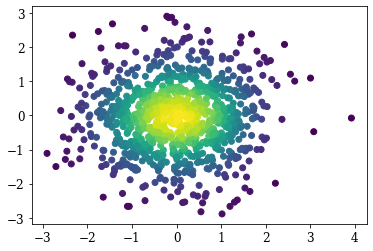

In [1041]:
rho = xr.apply_ufunc( vW, dists/h ).sum('b')


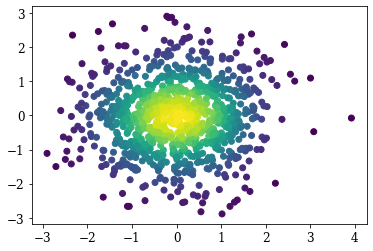

In [1043]:
plt.scatter( positions.loc[:,"x"], positions.loc[:,"y"], c=rho )

## Vector class

In [205]:
class Vector(ndarray):
    def __new__(cls, arr):
        return asarray(arr).view(cls)
    
    def __finalaize_array__(self, obj):
        if obj is None: return
        return
    
    @property
    def dim(self):
        return len(self.shape)
    
    def __abs__(self):
        return sqrt( tensordot(self, self, axes=(-1, -1)))
    


In [206]:
a = Vector([2,2])
abs(a)

2.8284271247461903

In [299]:
class VectorArray(ndarray):
    def __new__(cls, arr):
        return asarray(arr).view(cls)
    
    def __finalize_array(self, obj):
        if obj is None: return None
        return
    
    @property
    def dim(self):
        return self.shape[-1]
    
    @property
    def N(self):
        return self.shape[0]
    
    def xy(self, transpose=False):
        if T:
            return tuple(self.T)[::-1]
        return tuple(self.T)
    
    def cross_sub(self, other):
        otherslice = [None] + [slice(None)]*len(other.shape)
        selfslice = [slice(None)] + [None]*(len(other.shape)-1) + [slice(None)]
        return self[tuple(selfslice)] - other[tuple(otherslice)]
    
    def __abs__(self):
        print("abs")
        return sqrt( sum( self*self, axis=-1 ) )

In [28]:
N = 100
shape = (int(N/2), 2)
r = VectorArray( random.normal(0, 1, shape) )
print( r.shape )

NameError: name 'VectorArray' is not defined

In [238]:
print( abs(r.cross_sub(r)) )

abs
[[0.         3.59148917 2.81061062 ... 2.52486781 1.85098849 2.61804277]
 [3.59148917 0.         3.71016908 ... 1.09639498 1.75763937 0.98588448]
 [2.81061062 3.71016908 0.         ... 2.86838133 2.60618592 3.21491094]
 ...
 [2.52486781 1.09639498 2.86838133 ... 0.         0.67427647 0.35965339]
 [1.85098849 1.75763937 2.60618592 ... 0.67427647 0.         0.83148615]
 [2.61804277 0.98588448 3.21491094 ... 0.35965339 0.83148615 0.        ]]


In [702]:
class Index:
    def __init__(self, name):
        self.name = name
    
    def __repr__(self):
        return f"{self.name}:{self.__class__.__name__}"
    
    def __gt__(self, other):
        return self.name > other.name
    
class Particle(Index):
    pass
    
class Space(Index):
    pass

uniquesorted = lambda l: list(dict.fromkeys(sorted(l)))

class Vector:
    def __init__(self, arr, sig):
        self._arr = asarray(arr)
        self._sig = sig
    
    @property
    def signature(self):
        return self._sig
    
    @property
    def array(self):
        return self._arr
    
    def __repr__(self):
        return f"({ ', '.join([ f'{s.__name__}:{sh}' for s, sh in zip(self._sig, self._arr.shape) ]) })\n{self._arr}" 
    
    def __str__(self):
        return self.__repr__()
    
    def __getitem__(self, inds):
        try:
            return self._arr[inds]
        except IndexError:
            for ind, sig in zip(inds, self._sig):
                assert isinstance( ind, sig ), f"{ind} is not instance of {sig}"
            return IndexedVector( self._arr, inds )
    
    def __setitem__(self, inds, other):
        for i, s, o in zip(inds, self._sig, other.signature):
            assert isinstance(i, s), f"{i} is not an instance of {s}"
            assert s == o, f"{s} is not equal to {o}"
        self.__init__( other._base, other.signature )
        
class IndexedVector:
    def __init__(self, base, inds):
        self._base = base
        self._inds = inds
    
    @property
    def signature(self):
        return tuple( ind.__class__ for ind in self._inds )
    
    def _combine_indexes(self, other):
        return uniquesorted( self._inds + other._inds )

    def _get_slices(self, inds):
        return tuple( slice(None) if ind in self._inds else None for ind in inds )
    
    def _sliced_base(self, inds):
        return self._base[self._get_slices(inds)]
    
    def __add__(self, other):
        try:
            complex(other)
            return indexedVector( self._base + other, self._inds )
        except TypeError:
            inds = self._combine_indexes(other)
            return IndexedVector( self._sliced_base(inds) + other._sliced_base(inds), inds )
        
    def __mul__(self, other):
        try:
            complex(other)
            return IndexedVector( self._base*other, self._inds )
        except TypeError:
            inds = self._combine_indexes(other)
            return IndexedVector( self._sliced_base(inds) * other._sliced_base(inds), inds )
    
    def __pow__(self, other):
        try:
            complex(other)
            return indexedVector( self._base ** other, self._inds )
        except TypeError:
            inds = self._combine_indexes(other)
            return IndexedVector( self._sliced_base(inds) ** other._sliced_base(inds), inds )

    def __truediv__(self, other):
        try:
            complex(other)
            return IndexedVector( self._base/other, self._inds )
        except TypeError:
            inds = self._combine_indexes(other)
            return IndexedVector( self._sliced_base(inds)/other._sliced_base(inds), inds )

    def __radd__(self, other):
        return IndexedVector.__add__(self, other)
    
    def __rmul__(self, other):
        return IndexedVector.__mul__(self, other)
    
    def __rtruediv__(self, other):
        return IndexedVector.__mul__(self**(-1), other)
    
    def __neg__(self):
        return IndexedVector( -self._base, self._inds )
    
    def __sub__(self, other):
        return self + (-other)
        
    def sum(self, ind):
        axis = self._inds.index(ind)
        inds = [ i for i in self._inds if i != ind ]
        return IndexedVector( sum( self._base, axis=axis ), inds )
        
    def __repr__(self):
        return f"{', '.join([ f'{i}' for i, s in zip(self._inds, self.signature)])}\n{self._base}"
    
    def int(self):
        return IndexedVector( rint(self._base), self._inds )

In [703]:
x = Vector([[1.,2.],[3.,4.]], (Particle, Space))
x

(Particle:2, Space:2)
[[1. 2.]
 [3. 4.]]

In [704]:
i = Space('i')
j = Space('j')
a = Particle('a')
b = Particle('b')
y = Vector(None, (Particle, Particle, Space))
print( "ype", y, type(y), type(y[a,b,i]) )
y[a,b,i] = x[a,i] - x[b,i]
print( "y", y )
print( y[a,b,i] )
print( "dist", (y[a,b,i]*y[a,b,i]).sum(i) )
print( "*2", (y[a,b,i]*2).sum(i) )
print( (2*y[a,b,i]).sum(i) )
print( (y[a,b,i]/2).sum(i) )
print( (1./x[a,i]).sum(i) )

ype ()
None <class '__main__.Vector'> <class '__main__.IndexedVector'>
y (Particle:2, Particle:2, Space:2)
[[[ 0.  0.]
  [-2. -2.]]

 [[ 2.  2.]
  [ 0.  0.]]]
a:Particle, b:Particle, i:Space
[[[ 0.  0.]
  [-2. -2.]]

 [[ 2.  2.]
  [ 0.  0.]]]
dist a:Particle, b:Particle
[[0. 8.]
 [8. 0.]]
*2 a:Particle, b:Particle
[[ 0. -8.]
 [ 8.  0.]]
a:Particle, b:Particle
[[ 0. -8.]
 [ 8.  0.]]
a:Particle, b:Particle
[[ 0. -2.]
 [ 2.  0.]]
a:Particle
[1.5        0.58333333]


In [827]:
h = .5
shape = (1000, 2)
r = Vector( random.normal(0, 1, shape), (Particle, Space) )

In [828]:
print( (r[a,i]/h), floor(r[a,i]._base/h) )

a:Particle, i:Space
[[ 1.8545541   0.34897795]
 [ 1.77049507 -1.37472852]
 [ 2.78285421  1.86520722]
 ...
 [ 1.46404155 -0.38591944]
 [-2.21437782 -0.26885224]
 [-2.69530897  0.48159079]] [[ 1.  0.]
 [ 1. -2.]
 [ 2.  1.]
 ...
 [ 1. -1.]
 [-3. -1.]
 [-3.  0.]]


In [591]:
f[a] = neighbor.sum[b]( W( r[b] - r[a], h ) )
g[a] = neighbor.sum[b]( v[b] * Wp( r[a] - r[b], h ) )

NameError: name 'neighbor' is not defined

# Testing cppyy

In [13]:
!python3 -m pip install --upgrade pip
!pip3 install cppyy --user

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!export EXTRA_CLING_ARGS='-O2 -std=c++11'
!echo $EXTRA_CLING_ARGS

-O2 -mavx


In [2]:
# import os
# print( os.environ.get("EXTRA_CLING_ARGS") )
# os.environ["EXTRA_CLING_ARGS"] = "-std=c++11 -O2"
# print( os.environ.get("EXTRA_CLING_ARGS") )
import cppyy

In [3]:
print( "hey" )

hey


In [1]:
# %%file cppyy_test.py

import cppyy
print( dir(cppyy) )
cppyy.cppdef("""
int test(){
    return 5;
}
""")

# cppyy.add_include_path("/opt/versatushpc/softwares/root/5.34-gnu-5.3/include/root")
# cppyy.include("TROOT.h")
# cppyy.include("TFile.h")
# cppyy.include("TTree.h")

# # cppyy.add_library_path("/opt/spack/opt/spack/linux-centos7-x86_64/gcc-5.3.0/root-6.14.00-kpuyabmncxz47fftbv564gw3iq2p6njf/lib")
# # cppyy.load_library("Core")

# cppyy.cppdef("""
# void write(){
#     TFile file("exemplacppyy.root", "recreate");
#     TTree tree("tree");
    
#     return;
# }
# """)

# cppyy.gbl.write()

['__all__', '__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_backend', '_begin_capture_stderr', '_cpython_cppyy', '_end_capture_stderr', '_get_name', '_pythonization', '_sizes', '_standard_pythonizations', '_stdcpp_fix', '_stderr_capture', '_typeids', '_typemap', '_version', 'add_autoload_map', 'add_include_path', 'add_library_path', 'addressof', 'ape', 'bind_object', 'c_include', 'cppdef', 'cppexec', 'ctypes', 'gbl', 'include', 'line', 'load_library', 'load_reflection_info', 'local_pch', 'multi', 'nullptr', 'os', 'py', 'py_make_smartptr', 'set_debug', 'sizeof', 'sys', 'sysconfig', 'typeid', 'warnings']


True

In [2]:
cppyy.gbl.test()

5

# miscellaneous

In [26]:
import numpy as np
from functools import reduce
from scipy.sparse import csr_matrix

def binned_statistic(x, values, func, nbins, range):
    '''The usage is nearly the same as scipy.stats.binned_statistic''' 

    N = len(values)
    r0, r1 = range

    digitized = (float(nbins)/(r1 - r0)*(x - r0)).astype(int)
    row = digitized
    column = np.arange(N)
    S = csr_matrix((values, [row, column]), shape=(nbins, N))

    return [func(group) for group in np.split(S.data, S.indptr[1:-1])]

nested = [[1,2,3,4], [10,11], [9]]

values = reduce( lambda x,y: x + y, nested )
print( 'values', values )
lens = list(map( len, nested ))
print( 'lens', lens )
splits = [ sum(lens[:i]) for i in range(1,len(nested)) ]
print( 'splits', splits )
print( np.split( values, splits ) )
row, values = np.array( [ (ind, element) for ind, array in enumerate(nested) for element in array ] ).T
N = values.size
S = csr_matrix( (values, (row, np.arange(N))), shape=(row.max()+1, N) )
print( S.toarray() )
print( S.data )
print( S.indptr )
print( np.split(values, S.indptr[1:-1]) )
# print( 'list', S.tolil() )
print( 'sum', S.mean(axis=1) )

values [1, 2, 3, 4, 10, 11, 9]
lens [4, 2, 1]
splits [4, 6]
[array([1, 2, 3, 4]), array([10, 11]), array([9])]
[[ 1  2  3  4  0  0  0]
 [ 0  0  0  0 10 11  0]
 [ 0  0  0  0  0  0  9]]
[ 1  2  3  4 10 11  9]
[0 4 6 7]
[array([1, 2, 3, 4]), array([10, 11]), array([9])]
sum [[1.42857143]
 [3.        ]
 [1.28571429]]


In [58]:
!pip3 install numba --user

     |████████████████████████████████| 3.4 MB 22.2 MB/s eta 0:00:01     |███████████████▉                | 1.7 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 15.1 MB/s eta 0:00:01    |███▏                            | 2.5 MB 15.1 MB/s eta 0:00:02     |████████████████████▍           | 16.1 MB 15.1 MB/s eta 0:00:01     |███████████████████████▋        | 18.6 MB 15.1 MB/s eta 0:00:01
